In [1]:
import io
import os
import random
import datetime
from typing import Tuple

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

from google.colab import drive, files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    InputLayer,
    BatchNormalization,
    Input,
    Dropout,
    RandomFlip,
    RandomRotation,
    Resizing,
    Rescaling,
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import (
    BinaryAccuracy,
    FalsePositives,
    FalseNegatives,
    TruePositives,
    TrueNegatives,
    Precision,
    Recall,
    AUC,
    binary_accuracy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp

# **Define Functions**

In [2]:
def split_dataset(dataset: tf.data.Dataset,
                  train_ratio: float,
                  val_ratio: float,
                  test_ratio: float) -> Tuple[tf.data.Dataset,
                                              tf.data.Dataset,
                                              tf.data.Dataset]:
    """
    Split a dataset into training, validation, and test sets.

    Args:
        dataset (tf.data.Dataset): The input dataset to be split.
        train_ratio (float): The ratio of data to be used for training.
        val_ratio (float): The ratio of data to be used for validation.
        test_ratio (float): The ratio of data to be used for testing.

    Returns:
        tuple: A tuple containing the training, validation, and test datasets.
    """
    # Define the size of the dataset
    dataset_size = len(dataset)
    # Grab the training set
    train_dataset = dataset.take(int(train_ratio * dataset_size))
    # Define the part of the dataset without the training set
    rest_of_dataset = dataset.skip(int(train_ratio * dataset_size))
    # Split the rest of the dataset into validation and test sets
    val_dataset = rest_of_dataset.take(int(val_ratio * dataset_size))
    test_dataset = rest_of_dataset.skip(int(val_ratio * dataset_size))

    return train_dataset, val_dataset, test_dataset


import matplotlib.pyplot as plt
import tensorflow as tf
from typing import Optional

def plot_dataset_images_with_labels(train_dataset: tf.data.Dataset,
                                    amount_of_pictures: int,
                                    dataset_info: tfds.core.DatasetInfo,
                                    subplot_rows: int,
                                    subplot_columns: int):
    """
    Plot tf.data.dataset images with their corresponding labels.

    Args:
        train_dataset (tf.data.Dataset): The dataset containing images and labels.
        amount_of_pictures (int): The number of pictures to plot.
        dataset_info (tfds.core.DatasetInfo): Information about the dataset.
        subplot_rows (int): The number of subplot rows.
        subplot_columns (int): The number of subplot columns.

    Returns:
        None: This function does not return a value, or it returns None.
    """
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    for i, (image, label) in enumerate(train_dataset.take(amount_of_pictures)):
        ax = plt.subplot(subplot_rows, subplot_columns, i + 1)
        plt.imshow(image)
        plt.title(dataset_info.features['label'].int2str(label))
        plt.axis('off')

    plt.show()

# **Data Loading**

In [3]:
# Load the data from the malaria detection dataset.
# This dataset is based on the work of S. Rajaraman et al.
# https://peerj.com/articles/4568/?ref=https%3A%2F%2Fgithubhelp.com&utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_1&utm_medium=TrendMD
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteSKLY1F/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [93]:
#Define the splitting ratios of the dataset
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
# Split the dataset into train-, validation- and test-set.
train_dataset, val_dataset, test_dataset = split_dataset(dataset[0],
                                                         TRAIN_RATIO,
                                                         VAL_RATIO,
                                                         TEST_RATIO)

In [94]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [95]:
val_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# **Dataset Visualization**

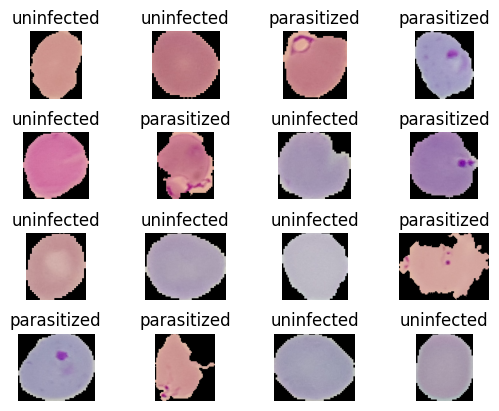

In [96]:
# Plot dataset images
plot_dataset_images_with_labels(train_dataset, 16, dataset_info, 4, 4)

# **Data Augmentation**

In [97]:
def resize_rescale(image, label):
    return tf.image.resize(image, (224, 224))/255.0, label

In [98]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)

In [99]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [100]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

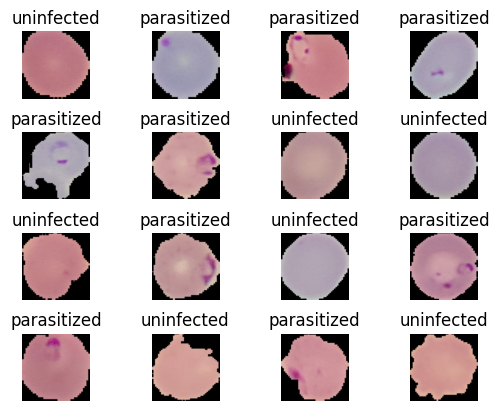

In [101]:
# Plot dataset images
plot_dataset_images_with_labels(train_dataset, 16, dataset_info, 4, 4)

In [102]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [103]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [104]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **Sequential Model**

In [105]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1,
           padding = 'valid', activation = 'relu'),
    BatchNormalization(),

    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 6, kernel_size = 3, strides = 1,
           padding = 'valid', activation = 'relu'),
    BatchNormalization(),

    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 6)       330       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 6)       24        
 chNormalization)                                                
                                                     

In [108]:
model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy'
)

In [109]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 100,
                    verbose = 2)

Epoch 1/100
689/689 - 50s - loss: 0.2307 - accuracy: 0.9237 - val_loss: 0.2599 - val_accuracy: 0.9172 - 50s/epoch - 73ms/step
Epoch 2/100
689/689 - 42s - loss: 0.1900 - accuracy: 0.9375 - val_loss: 0.2126 - val_accuracy: 0.9347 - 42s/epoch - 61ms/step
Epoch 3/100
689/689 - 39s - loss: 0.1756 - accuracy: 0.9441 - val_loss: 0.8646 - val_accuracy: 0.8555 - 39s/epoch - 57ms/step
Epoch 4/100
689/689 - 51s - loss: 0.1565 - accuracy: 0.9491 - val_loss: 0.3324 - val_accuracy: 0.9412 - 51s/epoch - 74ms/step
Epoch 5/100
689/689 - 39s - loss: 0.1914 - accuracy: 0.9343 - val_loss: 0.2192 - val_accuracy: 0.9249 - 39s/epoch - 56ms/step
Epoch 6/100
689/689 - 51s - loss: 0.1430 - accuracy: 0.9541 - val_loss: 0.2853 - val_accuracy: 0.9020 - 51s/epoch - 75ms/step
Epoch 7/100
689/689 - 39s - loss: 0.1214 - accuracy: 0.9606 - val_loss: 0.2062 - val_accuracy: 0.9408 - 39s/epoch - 57ms/step
Epoch 8/100
689/689 - 39s - loss: 0.1070 - accuracy: 0.9629 - val_loss: 0.2411 - val_accuracy: 0.9336 - 39s/epoch - 56

# **Defining an custom Model**

In [ ]:
class NeuralearnDense(Layer):
    def __init__(self, output_units, activation):
        super(NeuralearnDense, self).__init__()
        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape):
        self.w = self.add_weight(shape = (input_features_shape[-1], 
                                          self.output_units), 
                                 initializer = "random_normal", 
                                 trainable = True)
        self.b = self.add_weight(shape = (self.output_units,), 
                                 initializer = "random_normal", 
                                 trainable = True)

    def call(self, input_features):
        
        pre_output = tf.matmul(input_features, self.w) + self.b
        
        if(self.activation == "relu"):
            return tf.nn.relu(pre_output)
        elif(self.activation == "sigmoid"):
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output

In [ ]:
IM_SIZE = 224
custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),

                             NeuralearnDense(100, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(10, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(1, activation = "sigmoid"),

])
lenet_custom_model.summary()